# Model-based EM algorithm
**Clustering of polynomial curve**

(This was not apart of the coursework but a inspiration I had while doing a research course)


Potential relevant reading (not read yet):
- https://arxiv.org/abs/1312.7022

In [303]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Function
polyFunc = lambda t,b0,b1,b2: b0 + b1*(t) + b2*(t**2)

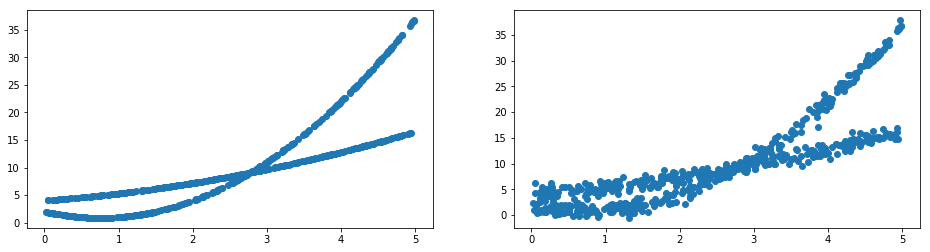

In [179]:
## Curve generation ##

# Samples per class
N_Samples = 300

# Set the parameters of the curves
c0_b0, c0_b1, c0_b2 = 2.0, -3, 2
c1_b0, c1_b1, c1_b2 = 4.0, 1.0, 0.3


# Initialize the x's and y's
x = np.random.uniform(low=0.0, high=5.0, size=(N_Samples*2))
clean_y = np.zeros((N_Samples*2))


# Generate the y's
for i in range(0, N_Samples):
    clean_y[i] = polyFunc(x[i], c0_b0, c0_b1, c0_b2)
for i in range(N_Samples, len(clean_y)):
    clean_y[i] = polyFunc(x[i], c1_b0, c1_b1, c1_b2)


# Add noise to y
gaus_noise = np.random.normal(loc=0.0, scale=0.8, size=(N_Samples*2))
noisy_y = np.add(clean_y, gaus_noise)
    
# Visualize the y's
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.scatter(x, clean_y)
plt.subplot(1,2,2)
plt.scatter(x, noisy_y)
plt.show()

In [373]:
## Algorithm ##
from scipy.optimize import curve_fit

# Log of Gaussian likelihood:
# https://math.stackexchange.com/questions/1307381/logarithm-of-gaussian-function-is-whether-convex-or-nonconvex
def univarLogGausLikelihood(x, mu, sigma=1.0):
    A = np.log( np.divide(1.0, (np.sqrt(2 * np.pi) * sigma)) )
    B = np.square(x-mu) / (2 * np.square(sigma))
    return A - B
    

# Standard deviation (sigma) of a group TODO: parameter is hard-coded
def computeClusterSigma(y, func, x, a, b, c):
    # Compute the predicted y for each x
    pred_y = np.zeros(np.shape(y))
    for i in range(len(x)):
        pred_y[i] = func(x[i], a, b, c) 
    
    # Compute differences
    abs_diff = np.abs( np.subtract(pred_y, y) )
    return np.average(abs_diff)
    
    

def polyEM(x, y, func, n_params=3, n_clusters=2, max_iters=20):
    # Randomly initialize the model parameters (row: cluster index; col: param)
    # last value of the parameters is the sigma (square root variance)
    params = np.abs( np.random.normal(loc=0.0, scale=2.0, size=(n_clusters, n_params+1)) )
    
    # Initialize label likelihood
    labelProb = np.zeros((len(x), n_clusters))
    
    # Keep track of total negative log likelihood
    totalLogLikelihood = np.zeros(max_iters)
    
    for iters in range(max_iters):
        ## Expectation step ##
        # Assign individuals based on closeness to curves
        for i in range(0, len(x)):
            for k in range(0, n_clusters):
                # Compute expected value given x
                curPred_y = func(x[i], params[k,0], params[k,1], params[k,2]) #NOTE this is hard-coding
                # Compute log likelihood of individual in cluster 
                labelProb[i,k] = univarLogGausLikelihood(y[i], curPred_y, sigma=params[k,-1])
                #labelProb[i,k] = univarLogGausLikelihood(y[i], curPred_y, sigma=1)
        
        # Store negative log likelihood
        totalLogLikelihood[iters] = np.sum(labelProb)
        
        ## Maximization step ##
        # Get all the individuals in each cluster
        curLabIdxs = np.argmax(labelProb, axis=1)
        # Fit the new parameters of each cluster
        for k in range(0, n_clusters):
            # Get datapoints
            curDataIdxs = np.where(curLabIdxs==k)
            curClus_x = np.take(x, curDataIdxs).flatten()
            curClus_y = np.take(y, curDataIdxs).flatten()
            
            # Skip if the size of the cluster is smaller than function parameter size (not sure if hacky)
            if len(curClus_x) < n_params:
                continue
            
            # Fit line
            fitted_param, fitted_cov = curve_fit(func, curClus_x, curClus_y)
            
            # Update parameters NOTE HARCODED PARAMETERS
            params[k,0:3] = fitted_param[0:3] 
            params[k,-1] = computeClusterSigma(curClus_y, func, curClus_x,
                                               fitted_param[0],fitted_param[1],fitted_param[2])
    
    
    ## Final
    finalLabIdxs = np.argmax(labelProb, axis=1)
    
    returnDict = {}
    returnDict['Labels'] = finalLabIdxs
    returnDict['Params'] = params
    returnDict['LogLikelihoods'] = totalLogLikelihood
    
    return returnDict
    
    

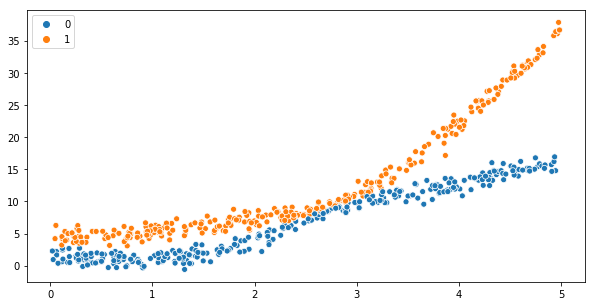

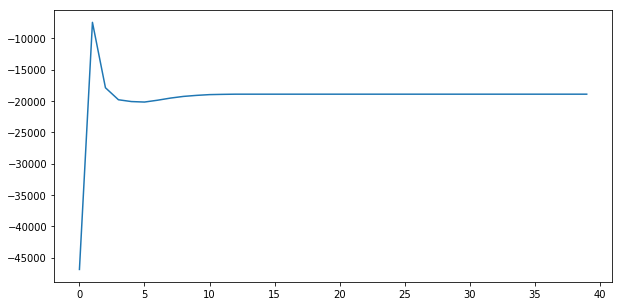

In [374]:
predDict = polyEM(x, noisy_y, polyFunc, n_params=3, n_clusters=2, max_iters=40)

# Plot
plt.figure(figsize=(10,5))
sns.scatterplot(x=x, y=noisy_y, hue=predDict['Labels'])
plt.show()
plt.figure(figsize=(10,5))
plt.plot(predDict['LogLikelihoods'])
plt.show()